<a href="https://colab.research.google.com/github/thesaifmustafa8/TECHIN513/blob/main/InClass_Week5_Saif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Saif Mustafa** TECHIN 513 - Week 5 Assignment

**Setup**

* Importing all necessary tensorflow packages 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

**Load Data**
* Loading data from Kaggle's Cats and Dogs Dataset
* Unzipping into Colab runtime directory 

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   122M      0  0:00:06  0:00:06 --:--:--  134M


**Filter out corrupted images**
* Data cleanup step
* Filterting out badly-encoded images that do not feature the string "JFIF" in their header.
  *  `tf.compat.as_bytes("JFIF")` converts the string JFIF to bytes
  * `fobj.peek(10)` theoretically returns the first 10 bytes of the file
  * `is_jfif` then checks if the converted "JFIF" string is in the result of `fobj.peek`


In [4]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


**Generate dataset**

In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages", 
    batch_size = batch_size, 
    image_size = image_size,
    validation_split=0.2,
    seed = 8, # to make the result reproducible
    subset="training" # needs validation split
) 

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages", 
    batch_size = batch_size, 
    image_size = image_size,
    validation_split=0.2,
    seed = 8,
    subset="validation" # needs validation split
) 

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [6]:
print(train_ds) # BatchDataset type object

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>


**Data Augmentation**

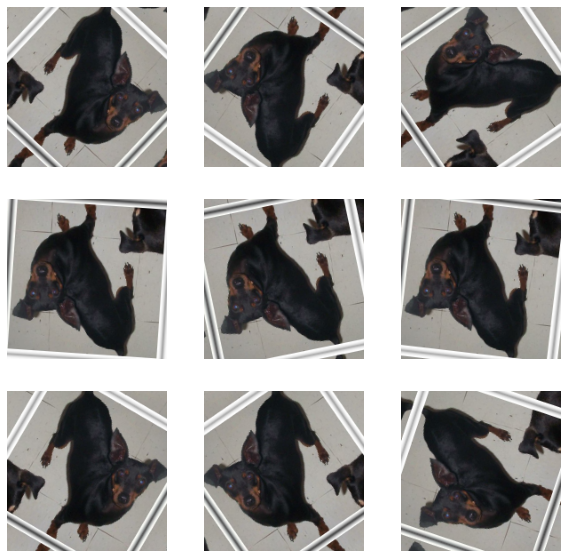

In [7]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"), # adding a new layer
  layers.RandomRotation(0.2), # adding a new layer
])

# shows up as only one layer later on
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Visualize data**

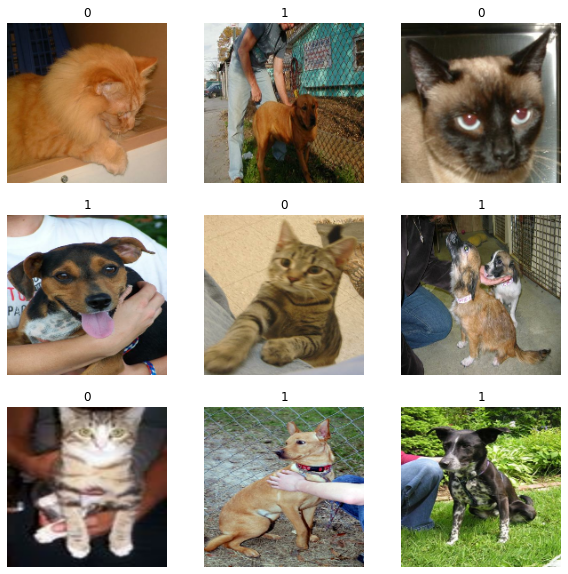

In [10]:
# it treats different directories as different classes
# labels are generated from the directory structure
# During preprocessing step, labels = 'inferred' by default
# label mode = 'int', and since we have 2 subfolders, we get either 0 or 1

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

**Build a Model**

You will need to build a small version of the Xception network. We haven't particularly tried to optimize the architecture; if you want to do a systematic search for the best model configuration, consider using KerasTuner.

Note that:

We start the model with the data_augmentation preprocessor, followed by a Rescaling layer.
We include a Dropout layer before the final classification layer.

In [11]:
# this method is constructing the different layers 
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x) # Normalization: you're reassigning RGB (0-255) values to values between 0 and 1.0
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) # resizing the image by using a kernel, 32 = filters, 3 = kernal size, 32 is the output dimension
    x = layers.BatchNormalization()(x) # output layer changed from 180x180 to 90x90 because stride is 2
    x = layers.Activation("relu")(x) # 

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

**Create the Model**

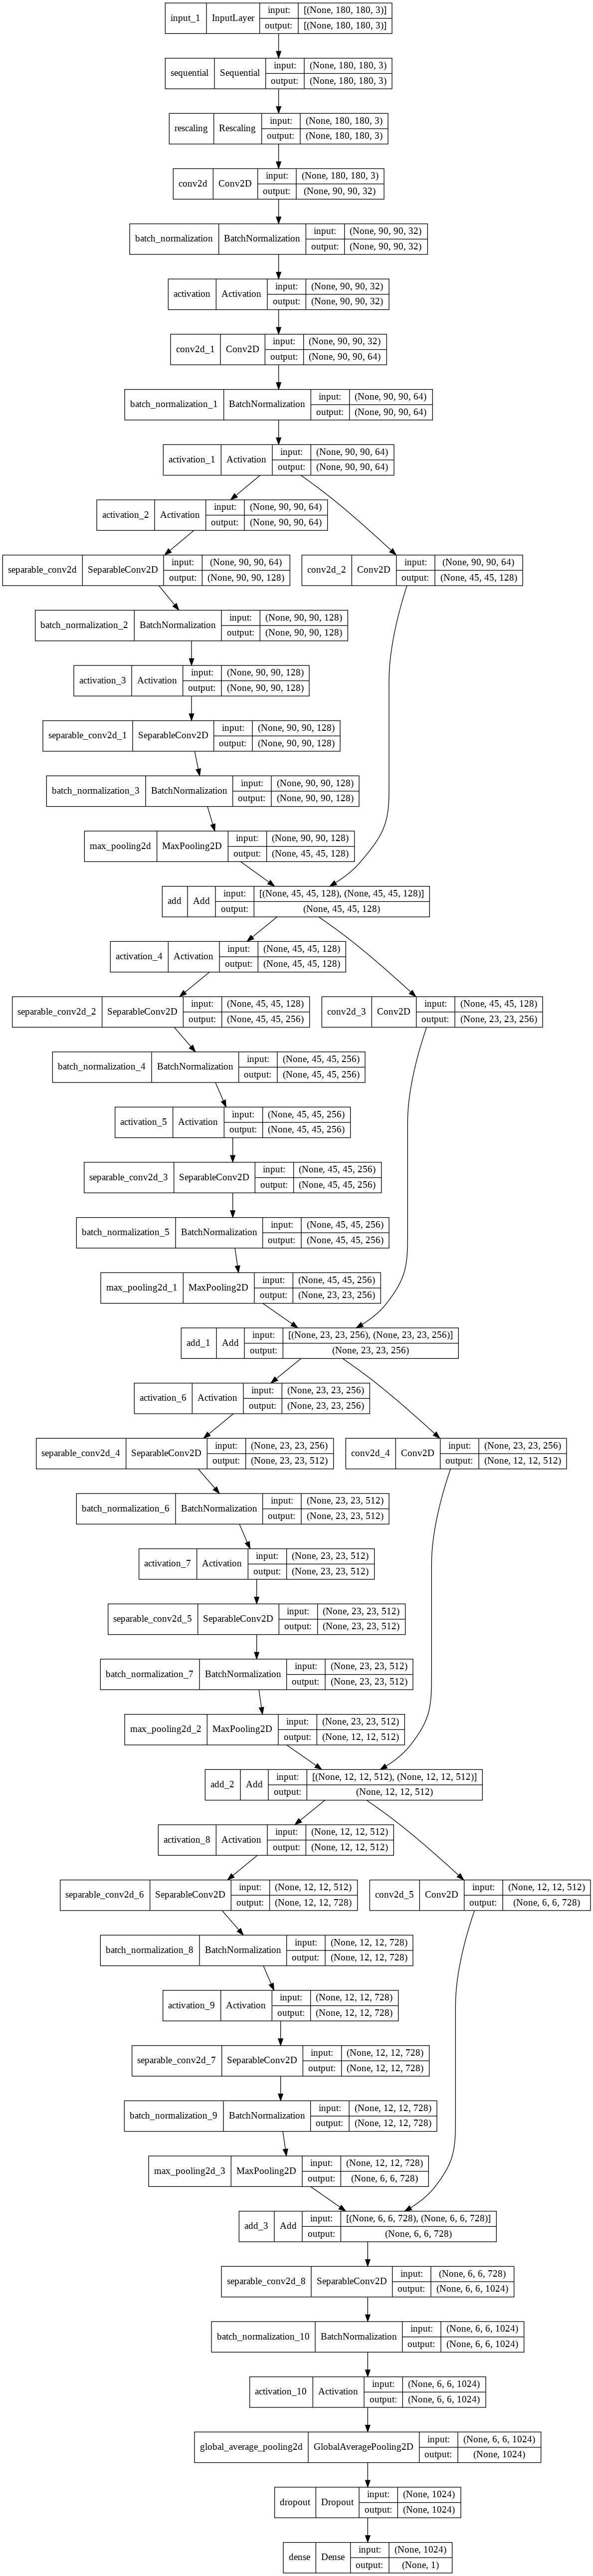

In [12]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

**Train model**

In [14]:
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5
586/586 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.6707

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


586/586 [==============================] - 297s 495ms/step - loss: 0.6275 - accuracy: 0.6707 - val_loss: 1.0111 - val_accuracy: 0.5463
Epoch 2/5
586/586 [==============================] - 288s 491ms/step - loss: 0.5545 - accuracy: 0.7166 - val_loss: 0.5499 - val_accuracy: 0.7253
Epoch 3/5
586/586 [==============================] - 288s 491ms/step - loss: 0.5016 - accuracy: 0.7577 - val_loss: 0.6282 - val_accuracy: 0.6995
Epoch 4/5
586/586 [==============================] - 288s 491ms/step - loss: 0.4594 - accuracy: 0.7850 - val_loss: 0.8473 - val_accuracy: 0.6241
Epoch 5/5
586/586 [==============================] - 289s 492ms/step - loss: 0.4219 - accuracy: 0.8105 - val_loss: 1.0906 - val_accuracy: 0.6057


**Run inference on new data**

[[0.4455841]]
This image is 55.44 percent cat and 44.56 percent dog.


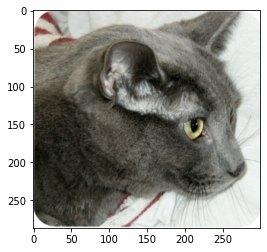

In [23]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)

img_test = plt.imread("/content/PetImages/Cat/6779.jpg")

plt.imshow(img_test)

img_flatten = keras.preprocessing.image.img_to_array(img)
img_flatten = tf.expand_dims(img_flatten, 0) 

predictions = model.predict(img_flatten)
print(predictions)

score = predictions[0]

print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)